# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train = train['features'], train['labels']
X_test_raw, y_test = test['features'], test['labels']


# Read Classes 
reader = list(csv.DictReader(open("signnames.csv")))
label_dict = {}
for row in reader:
    label_dict[row['ClassId']]=row['SignName']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train_raw.shape[0]

# TODO: Number of testing examples.
n_test = X_test_raw.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = [32,32]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(label_dict.keys())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

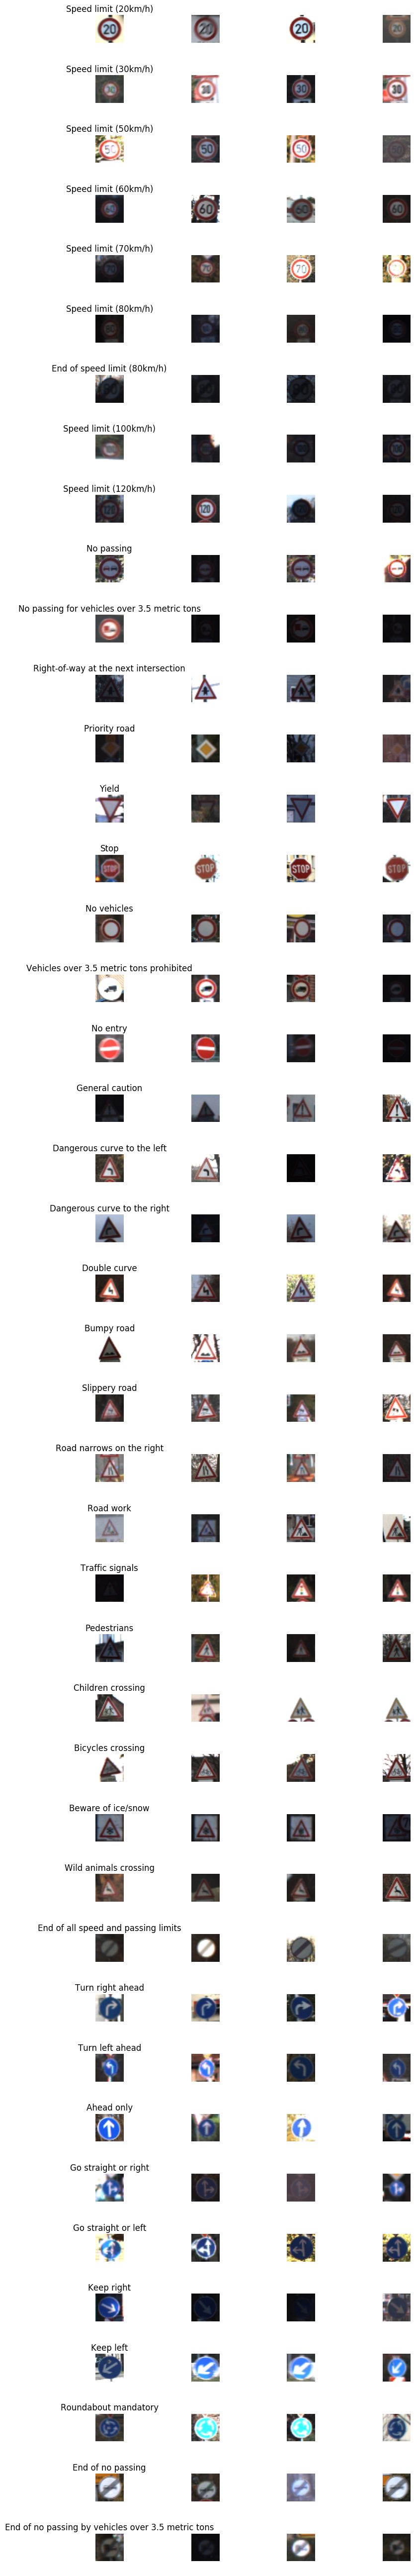

[  210.  2220.  2250.  1410.  1980.  1860.   420.  1440.  1410.  1470.
  2010.  1320.  2100.  2160.   780.   630.   420.  1110.  1200.   210.
   360.   330.   390.   510.   270.  1500.   600.   240.   540.   270.
   450.   780.   240.   689.   420.  1200.   390.   210.  2070.   300.
   360.   240.   240.]
['Traffic signals', 'Pedestrians', 'Speed limit (120km/h)', 'Right-of-way at the next intersection', 'Double curve', 'End of no passing', 'Keep right', 'No passing', 'Dangerous curve to the left', 'No entry', 'Bumpy road', 'Road narrows on the right', 'Turn right ahead', 'Roundabout mandatory', 'Speed limit (100km/h)', 'Turn left ahead', 'Speed limit (50km/h)', 'Yield', 'Dangerous curve to the right', 'Keep left', 'End of no passing by vehicles over 3.5 metric tons', 'Go straight or left', 'Children crossing', 'End of speed limit (80km/h)', 'Slippery road', 'General caution', 'Priority road', 'No vehicles', 'Speed limit (20km/h)', 'No passing for vehicles over 3.5 metric tons', 'Go st

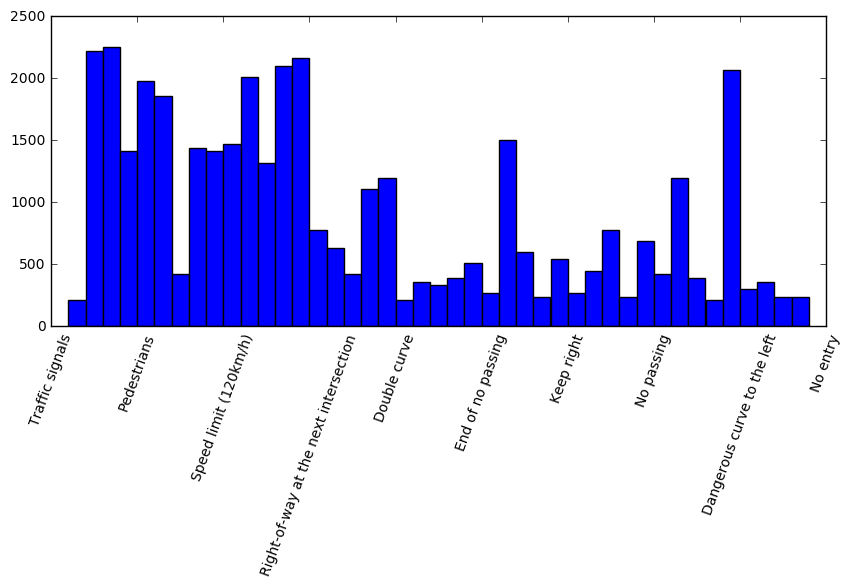

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline


def visualize(inputs,labels):
    
    n_samples = 4

    fig,axes = plt.subplots(n_classes, n_samples, figsize=(8,52))
    fig.subplots_adjust(hspace=0.3, wspace=0.05)

    for key,value in label_dict.items():
        row = int(key)
        signs = list(filter(lambda x: x[0] == row, zip(labels,inputs)))
        axes[row,0].set_title(value)
        for i in range(0,n_samples):
            sign = random.choice(signs)
            #axes[row,i].title("Sign:",value)
            axes[row,i].axis('off')
            axes[row,i].imshow(sign[1])

    fig.tight_layout()    
    plt.show()

def histogram(inputs):
    counts = np.zeros(n_classes)
    for label_id in inputs:
        counts[label_id] += 1
        
    fig, ax = plt.subplots(1,1,figsize=(10,4))
    
    ind = np.arange(n_classes)
    width = 1
    plt.xticks(rotation=70)
    ax.bar(ind+width, counts, width=width)
    ax.set_xticklabels(list(label_dict.values()))
    
    print(counts)
    print(list(label_dict.values()))
    
    
    
# Sample of 5 of the images for each sign type
visualize(X_train_raw,y_train)

# Histogram of occurances. Higher occurance should fit data more accurately
histogram(y_train)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2
import numpy as np
from scipy import ndimage


def remove_noise(inputs):
    gray_input = []
    for img in inputs: 
        
        img_merge = ndimage.median_filter(img, 3)
         
        gray_input.append(img_merge)
    
    return gray_input

def local_normalize_histogram(inputs):
    gray_input = []
    for img in inputs: 
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
        b = clahe.apply(img[:,:,0])
        g = clahe.apply(img[:,:,1])
        r = clahe.apply(img[:,:,2])
    
        
        img_merge = cv2.merge((b,g,r))
         
        gray_input.append(img_merge)
    
    return gray_input
    
    

def to_bw(inputs):
    gray_input = []
    for img in inputs: 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        gray_img = gray_img[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        gray_img = clahe.apply(gray_img)
        gray_img_tf =  gray_img[:, :, np.newaxis]
        gray_input.append(gray_img_tf)
    
    return gray_input

def append_intensity_layer(inputs):
    gray_input = []
    for img in inputs: 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        
        b = img[:,:,0]
        g = img[:,:,1]
        r = img[:,:,2]
        i = gray_img[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        il = clahe.apply(i)

        img_merge = cv2.merge((b,g,r,il))
         
        gray_input.append(img_merge)
    
    return gray_input

def to_yuv(inputs):
    gray_input = []
    for img in inputs: 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        
        y = img[:,:,0]
        cr = img[:,:,1]
        cb = img[:,:,2]
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        yl = clahe.apply(y)
        
        img_merge = cv2.merge((yl,cr,cb))
         
        gray_input.append(img_merge)
    
    return gray_input

def illumination_correction(inputs):
    gray_input = []
    for img in inputs: 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        
        l = img[:,:,0]
        a = img[:,:,1]
        b = img[:,:,2]
        
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        
        img_merge = cv2.merge((cl,a,b))
         
        gray_input.append(img_merge)
    
    return gray_input


X_train = X_train_raw
X_test = X_test_raw
#X_train = remove_noise(X_train_raw)
#X_test = remove_noise(X_test_raw)
#X_train = to_bw(X_train_raw)
#X_test = to_bw(X_test_raw)

#X_train = append_intensity_layer(X_train_raw)
#X_test = append_intensity_layer(X_test_raw)
#X_train = to_yuv(X_train_raw)
#X_test = to_yuv(X_test_raw)
#X_train = illumination_correction(X_train_raw)
#X_test = illumination_correction(X_test_raw)

#X_train = local_normalize_histogram(X_train_raw)
#X_test = local_normalize_histogram(X_test_raw)


#visualize(X_train,y_train)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_




**Answer:**

### Review 

I examined a number of different methods for cleaning up the data set and none of which showed significant enough improvement in the test and validation data sets to warrant continuing to use them. I kept them here for future use. Here are the methods I tried; 

1. Remove Noise (remove_noise) - Use a median filter on the image to reduce the random noise in the image
2. B/W (to_bw) - In this case it was using the intensity (Y) channel from the YUV conversion. (1) Showed that YUV intensity worked better than straight grayscale so that approach was tried. CLAHE was applied to increase the contrast
3. Append Intensity Layer - Building on 2. the colour layer was tested and had some value so I tried appending the intensity layer (from item 2) into the color. 
4. To YUV - From the paper (1), I included the intensity layer, Applied a CLAHE to the intensity layer and added the CrCb colors also
5. Illumination Correction - Convert to LAB color and apply CLAHE to all the layers 
6. Histogram Normalization - Apply CLAHE to all layers


As I mentioned the preprocessing did not improve the validation or testing significantly but it also didn't degrade the results significantly. In the case of the b/w - intensity only layer the results did drop by around 5% which would indicate that there is some information used to classify within the color layers. The other methods seemed to do a lot of processing without a statistically significant change



#### References
1. P. Sermanet and Y. LeCun, "Traffic sign recognition with multi-scale Convolutional Networks," The 2011 International Joint Conference on Neural Networks, San Jose, CA, 2011, pp. 2809-2813.

2. CLAHE - see http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import ndimage 

def rotate(img,rotation=0.):
    rows = img.shape[0]
    cols = img.shape[1]

    M = cv2.getRotationMatrix2D((cols/2,rows/2),rotation,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

def translate(img,dx,dy):
    rows = img.shape[0]
    cols = img.shape[1]

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
def randomize_img(img):
    rows = img.shape[0]
    cols = img.shape[1]

    # translate
    Mt = np.float32([[1,0,random.gauss(0,5)],[0,1,random.gauss(0,5)]])
    # rotation
    Mr = M = cv2.getRotationMatrix2D((cols/2,rows/2),random.gauss(0,2),1)
    
    M = np.matmul(Mt,Mr)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
    

X_train_set, X_validation, y_train_set, y_validation = train_test_split(list(X_train),list(y_train), test_size=0.15, random_state=0)

idx = np.random.choice(np.arange(len(X_train_set)), 5000, replace=False)

for i in range(0,len(idx)):
    img_copy = X_train_set[i].copy()
    img_copy = ndimage.rotate(img_copy,random.gauss(0,5),reshape=False)
    #img_copy = ndimage.median_filter(img_copy, 3)
    X_train_set.append(img_copy)
    y_train_set.append(y_train_set[i])


print("Number of training examples =", len(X_train_set))
print("Number of validation examples =", len(X_validation))
print("Number of testing examples =", len(X_test))

X_train_set,y_train_set = shuffle(X_train_set,y_train_set)


Number of training examples = 38327
Number of validation examples = 5882
Number of testing examples = 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

###  Review

The process for setting up the training/validations and testing data was done in a number of phases. 

#### Phase 1
The first attempt was to do the minimal possible. The training data was split into 60% training and 40% validation. Testing data was used from the imported data. The model then was run through a number of times. The test results are shown below. The validation results were around 94% with testing results usually less than 90%. 

#### Phase 2
I experimented with increasing the training/validation split and found that larger training sets produced better validation results. I eventually moved the split to 85/15 for training and validation results

#### Phase 3 
The last phase was used to supplement the training set with additional values. For n iterations, I copied the image, applied either a translation, rotation or median filter to the image and added it back into the dataset. Rotation (+/- 5 degrees) proved to add the most robustness in the data sets. In the end I settled on ~5000 added items. The experiments at this stage were already validating at around 99.4% so there was very little difference between 5000 and 40000 items. (Except for the added computation time) 


#### Notes
One important realization was to apply the shuffle of the training set at this stage. Even with the shuffle applied for each batch, the results seemed to validate well enough but failed with the testing set. I suspect this is because the model was always converging with the same small batches. By shuffling the entire dataset we added enough variation for a more robust solution. 





In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 20
BATCH_SIZE = 512
n_featuremaps = X_train[0].shape[2]

rate = 0.001


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.tanh(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.05
    
    layer_depth = {
    'layer_1': 50,
    'layer_2': 100,
    'layer_3' : 400,
    'layer_4' : 200,
    'out' : n_classes    
    }

    # Store layers weight & bias
    weights = {
        'layer_1': tf.Variable(tf.truncated_normal(
            shape=(5, 5, n_featuremaps, layer_depth['layer_1']),mean=mu,stddev=sigma)),
        'layer_2': tf.Variable(tf.truncated_normal(
            shape=(5, 5, layer_depth['layer_1'], layer_depth['layer_2']),mean=mu,stddev=sigma)),
        'layer_3': tf.Variable(tf.truncated_normal(
            shape=(5*5*layer_depth['layer_2'], layer_depth['layer_3']),mean=mu,stddev=sigma)),
        'layer_4': tf.Variable(tf.truncated_normal(
            shape=(layer_depth['layer_3'], layer_depth['layer_4']),mean=mu,stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal(
            shape=(layer_depth['layer_4'], layer_depth['out']),mean=mu,stddev=sigma))
    }
    biases = {
        'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
        'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
        'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3'])),
        'layer_4': tf.Variable(tf.zeros(layer_depth['layer_4'])),
        'out': tf.Variable(tf.zeros(layer_depth['out']))
    }

    
    # Layer 1: Convolutional. 
    layer_1 = conv2d(x,weights['layer_1'],biases['layer_1'])

    # Pooling.
    layer_1 = maxpool2d(layer_1)

    # Layer 2: Convolutional. 
    layer_2 = conv2d(layer_1,weights['layer_2'],biases['layer_2'])

    # Pooling.
    layer_2 = maxpool2d(layer_2)

    # Flatten.
    fc1 = flatten(layer_2)
    
    # Layer 3: Fully Connected. 
    layer_3 = tf.add(tf.matmul(fc1,weights['layer_3']),biases['layer_3'])                           
    # Activation.
    layer_3 = tf.nn.tanh(layer_3)  
    
    #layer_3 = tf.nn.dropout(layer_3,0.75)
     
    # Layer 4: Fully Connected. 
    layer_4 = tf.add(tf.matmul(layer_3,weights['layer_4']),biases['layer_4']) 
    # Activation.
    layer_4 = tf.nn.tanh(layer_4) 
   
    logits = tf.add(tf.matmul(layer_4,weights['out']),biases['out'])                   
                               
    return logits


x = tf.placeholder(tf.float32, (None, 32, 32, n_featuremaps))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = rate)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Review

The approach to the architecture was to start with a convolution network, which is designed to handle images very well. LeNet-5 architecture(1), in addition to being taught in the class, has been proven to show excellent results with both the MNIST and this data set in particular. It seemed like a good fit for this project. 

#### Architecture

The architecture and source was modified from here (https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb). That solution was designed to handle the MNIST data set so it had to be modified for the traffic data set. Sermanet and LeCun(2) modified their LeNet architecture for the traffic sign dataset, and those parameters provided guidance for the changes. 

layer 1 - Convolution - 32x32x3 to 28x28x50, subsampled (max) to 14x14x50.

layer 2 - Convolution - 14x14x50 to 10x10x100, subsampled (max) to 5x5x100.

layer 3 - Full connection 5x5x100 to 400

layer 4 - Full connection to 200

output - 43 classes. 



#### References
1. LeCun, Y., Bottou, L., Bengio, Y., and Haffner, P. (1998d). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278–2324.

2. P. Sermanet and Y. LeCun, "Traffic sign recognition with multi-scale Convolutional Networks," The 2011 International Joint Conference on Neural Networks, San Jose, CA, 2011, pp. 2809-2813.

In [12]:
### Train your model here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_set)
    
    
    p_validation_accuracy = 0 
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train_set, y_train_set)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_set[offset:end], y_train_set[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        delta = abs(validation_accuracy - p_validation_accuracy)
        print("Delta {:.3f}".format(delta))
        if delta < 0.0005:
            break
            
        p_validation_accuracy = validation_accuracy
        
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")
    print("Testing..")
    
    


Training...

EPOCH 1 ...
Validation Accuracy = 0.954
Delta 0.954
EPOCH 2 ...
Validation Accuracy = 0.983
Delta 0.030
EPOCH 3 ...
Validation Accuracy = 0.985
Delta 0.002
EPOCH 4 ...
Validation Accuracy = 0.990
Delta 0.006
EPOCH 5 ...
Validation Accuracy = 0.991
Delta 0.001
EPOCH 6 ...
Validation Accuracy = 0.993
Delta 0.002
EPOCH 7 ...
Validation Accuracy = 0.993
Delta 0.000
Model saved
Testing..


In [13]:
import tensorflow as tf
import random

prediction = tf.argmax(tf.nn.softmax(logits), 1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('results/lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))



Test Accuracy = 0.961


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**


Inside the architecture there were a number of parameters that could be adjusted for fit; 

1. Number of Epochs
2. Batch Sizes
3. Layer 1-4 size
4. Activation Method
5. Distribution of initial weights and biases
6. Convolution (stride and filter sizes) 
7. Optimizers
8. Learning rate

The selection of those parameters was done in a trial-and-error method. All the experiments are shown in the training section below. Sermanet and LeCun (1) provided some excellent guidelines on the parameters that worked for them. Those were used to provide some guidance on the experiments.  


#### Notes

There was some experimentation with the architecture (number of layers, dropouts, etc..) but they didn't produce more accurate results. 

#### References
1. P. Sermanet and Y. LeCun, "Traffic sign recognition with multi-scale Convolutional Networks," The 2011 International Joint Conference on Neural Networks, San Jose, CA, 2011, pp. 2809-2813.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

#### Final Model 

Here are the parameters for the final model 

1. Number of Epochs
    20-25. Typically with the Adam Optimizer the model converged in 10-15 iterations. In terms of accuracy there was very little difference between 15-25 epochs. 
    
2. Batch Sizes
    Larger batch sizes worked better on the estimation, up to around 500 items. I'm not sure why this was the case but eventually 512 was chosen. 

3. Layer 1-4 size
    Convolution layers used 50,100 filters. Full Layers used 400 and 200 nodes, in that order. 

4. Activation Method
    LeNet-5 used ReLU activation for the MNIST dataset but using tanh produced much better results. Tanh added some non-linearities that worked well with the data. 

5. Distribution of initial weights and biases
    Minimizing the sigma of the inital parameters helped the convergence. Selecting 0.05 for the sigma (mu=0) helped it converge faster

6. Convolution (stride and filter sizes)
    The 5x5 filter, 1 stride all worked very well and no changes were made here. 
7. Optimizers
    Tried both Gradient Descent and Adam. Adam converged much faster and was used in the data set. 
8. Learning rate
    Stuck with 0.001. Modifying this either didn't change the value or caused it to converge much slower. 



#### Experimentation

As mentioned above, the testing and validation occurred over many (many) iterations. There was some guidance in the attached papers but the experimentation tried to determine which parameters had the correct impact on the test/validation results. As a rule, I tried to select the parameters that would have both a high training accuracy and testing accuracy. The testing accuracy was used as the primary benchmark for accurate results. 


Experiment 

** 1. No pre-processing, 40% validation data. **

`
Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 6,
    'layer_2': 16,
    'layer_3' : 120,
    'layer_4' : 80,
    'out' : n_classes    
    }
    Epochs:10
`

** Results: **

> Training accuracy 0.944
> Test Accuracy = 0.857


** 2. B/W source, 40% validation **

`Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 6,
    'layer_2': 16,
    'layer_3' : 120,
    'layer_4' : 80,
    'out' : n_classes    
    }
    Epochs:10
`

** Results: **
> Training accuracy 0.958
> Test Accuracy = 0.890

(using 20 epoch)
>Validation Accuracy = 0.953
>Test Accuracy = 0.873

(using tanh vs relu)
>Validation Accuracy = 0.969
>Test Accuracy = 0.917

(using gradient descent)
>Stopped after 20, slow convergence
>Validation Accuracy = 0.838
>Test Accuracy = 0.796

(using batch 256)
>Validation Accuracy = 0.956
>Test Accuracy = 0.889

(adding 25% dropout layer after layer 3) 
>Validation Accuracy = 0.922
>Test Accuracy = 0.854

**Note: B/w did not seem to improve accuracy, but it did improve the speed considerably. Holding the images as B/W and adjusting the other parameters might save processing time. **


** 3. B/W source, 40% validation **


`Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3' : 120,
    'layer_4' : 80,
    'out' : n_classes    
    }
    Epochs: 20
`
** Results **
>Validation Accuracy = 0.944
>Test Accuracy = 0.863  
 

** 4. YUV (Y-Channel only), 40% Validation **

`Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 6,
    'layer_2': 16,
    'layer_3' : 120,
    'layer_4' : 80,
    'out' : n_classes    
    }
`    
 
** Results **  
(tanh) (20 epochs - roughly the same for 40 epochs) 
>Validation Accuracy = 0.949
>Test Accuracy = 0.884

** 5. color, 40% validation **

`Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3' : 120,
    'layer_4' : 80,
    'out' : n_classes    
    }
    Epochs: 20
`

** Results **
(tanh)(40 epochs)
>Validation Accuracy = 0.967
>Test Accuracy = 0.906


** 6. color, 40% validation **

`Config:
    mu = 0
    sigma = 0.1
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3' : 400,
    'layer_4' : 200,
    'out' : n_classes    
    }
    Epochs: 20
`

** Results **
>Validation Accuracy = 0.973
>Test Accuracy = 0.914

(using 0.25 dropout)
>Validation Accuracy = 0.979
>Test Accuracy = 0.932

(using appending intensity layer , 0.25 dropout)
>Validation Accuracy = 0.965
>Test Accuracy = 0.914

(using yuv contrast , 0.25 dropout)
>Validation Accuracy = 0.967
>Test Accuracy = 0.914


** 7. color, 15% validation **

`Config:
    mu = 0
    sigma = 0.05
    learning_rate = 0.001
    layer_depth = {
    'layer_1': 50,
    'layer_2': 100,
    'layer_3' : 400,
    'layer_4' : 200,
    'out' : n_classes    
    }
    Epochs: 20
`

** Results ** 
>Validation Accuracy = 0.995
>Test Accuracy = 0.972

(dropout 0.25)
>Validation Accuracy = 0.984
>Test Accuracy = 0.942

(B/w)
>Validation Accuracy = 0.992
>Test Accuracy = 0.961

(yuv contrast)
>Validation Accuracy = 0.992
>Test Accuracy = 0.948


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

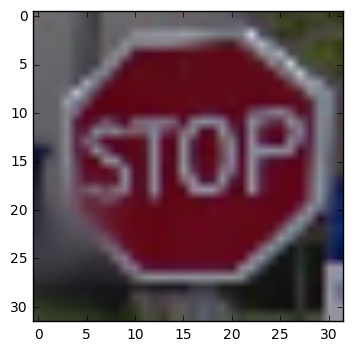

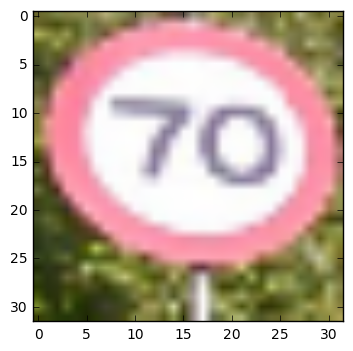

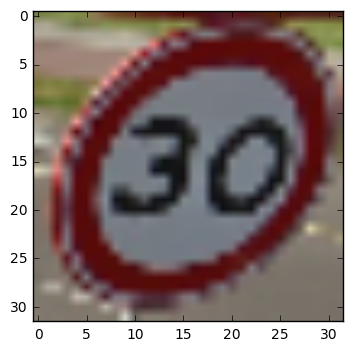

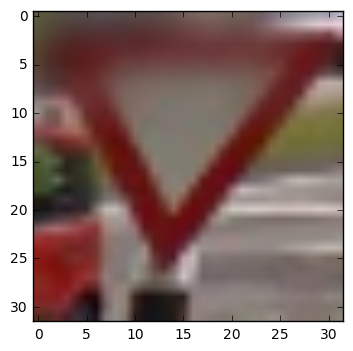

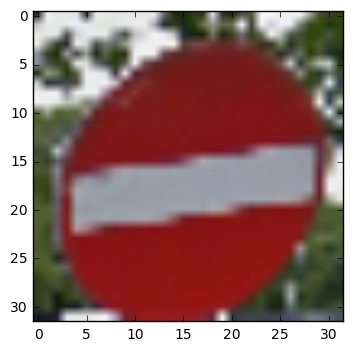

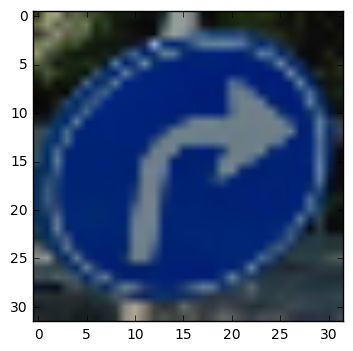

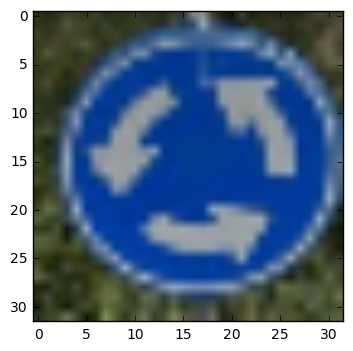

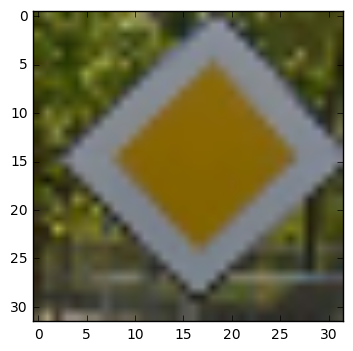

In [14]:

### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from os import listdir
from os.path import isfile, join
import numpy
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


def load_images():
    testpath='test_images/'
    onlyfiles = [ f for f in listdir(testpath) if isfile(join(testpath,f)) ]
    images = numpy.empty(len(onlyfiles), dtype=object)
    for n in range(0, len(onlyfiles)):
        img = cv2.imread( join(testpath,onlyfiles[n]) )
        img = cv2.resize(img, (32,32)) 
        img = img[:,:,::-1]
        images[n] = img
    return images


def visualize_test(inputs):

    for index,img in enumerate(inputs):
        plt.figure(index+1)
        plt.imshow(img)
        
    
    plt.show()


X_sample = load_images()
visualize_test(X_sample)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The images were selected from different screenshots within Google StreetView. It seemed like a good source of traffic information and can represent near actual field information. 

Some issues with the dataset might be; 
1. The images are projected from a central 360 camera. This will cause some warping in the images. (The addition of the rotate images probably helped this significantly) 
2. The images are collected on clear visibility days. This makes them much easier to identify and might not give an accurate representation of the quality of the model 



Prediction Ids: [14 38  1 13 17 33 40 12]


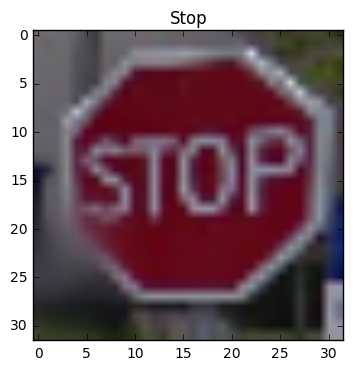

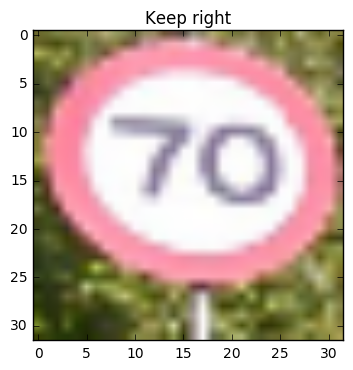

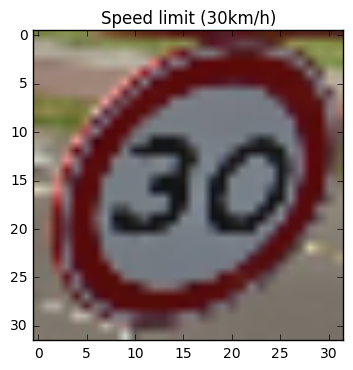

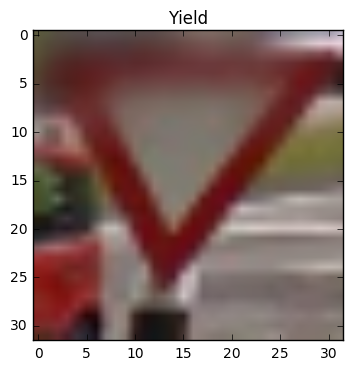

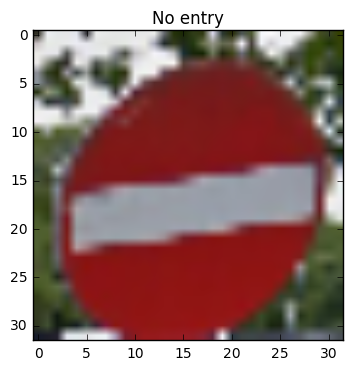

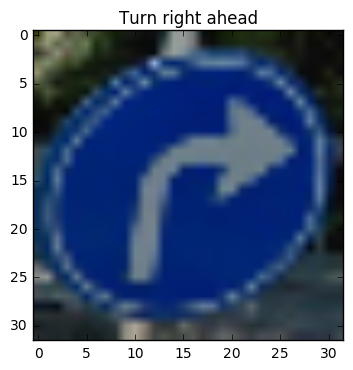

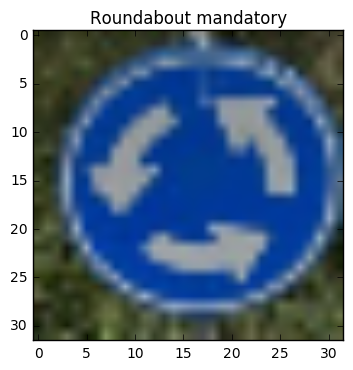

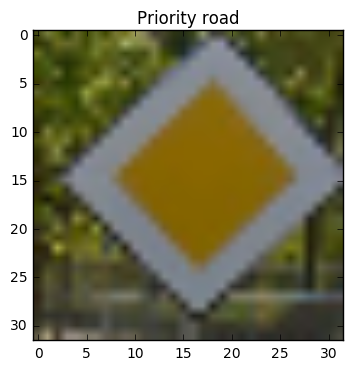

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import random

prediction = tf.argmax(tf.nn.softmax(logits), 1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('results/lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    results = sess.run(prediction, feed_dict={x: list(X_sample)})
    print("Prediction Ids:",results)
    
    for index, result in enumerate(results):
        plt.figure(index+1)
        plt.title(label_dict.get(str(result)))
        plt.imshow(X_sample[index])
    
    plt.show()
    
    

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model accurately predicted the 8 signs collected from the screenshots. In most cases it was predicted with a high degree of certainty (see below). 


#### Notes
Processing of the test images was important. The model likely wouldn't handle a large amount of whitespace around the images or if the image only included a partial sign. Having the images prepared correctly helped the solution.  


Stop : 100% , Speed limit (30km/h) : 0% , No entry : 0%
Keep right : 24% , Speed limit (50km/h) : 10% , No passing : 8%
Speed limit (30km/h) : 75% , Speed limit (20km/h) : 14% , Speed limit (70km/h) : 3%
Yield : 90% , End of no passing : 3% , Children crossing : 2%
No entry : 100% , Bumpy road : 0% , Stop : 0%
Turn right ahead : 100% , Keep left : 0% , Roundabout mandatory : 0%
Roundabout mandatory : 100% , Keep left : 0% , Turn left ahead : 0%
Priority road : 100% , End of no passing by vehicles over 3.5 metric tons : 0% , Traffic signals : 0%


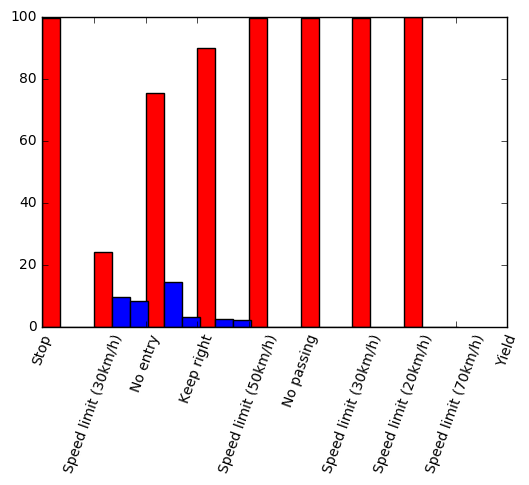

In [50]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import random

evaluation = tf.nn.top_k(tf.nn.softmax(logits), k=3)

def as_percentage(val):
    return "{0:.0f}%".format(val * 100)

  
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('results/lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    results = sess.run(evaluation, feed_dict={x: list(X_sample)})
    
    values = []
    labels = []

    for i,row in enumerate(results.values):
        
        indices = results.indices[i]
      
        row_values = []
        row_labels = []
        for j in range(3):    
            row_values.append(row[j]*100)
            labels.append(label_dict.get(str(indices[j])))    
        
        values.append(row_values)
        #labels.append(row_labels)
        
    
        print(label_dict.get(str(indices[0])),":",as_percentage(row[0]),","
              ,label_dict.get(str(indices[1])),":",as_percentage(row[1]),","
              ,label_dict.get(str(indices[2])),":",as_percentage(row[2]))
    
    ind = np.arange(8)  
    width = 0.35       

    fig, ax = plt.subplots()
    ax.bar(ind,[i[0] for i in values],width,color='r')
    ax.bar(ind+width,[i[1] for i in values],width,color='b')
    ax.bar(ind+2*width,[i[2] for i in values],width,color='b')
    
    ax.set_xticklabels(labels)
    plt.xticks(rotation=70)
    plt.show()
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

From the results above, the results from the model showed a very high degree of certainty. The only outlier (at ~30% confidence) was the 70km/h speed sign. This could be due to the amount of whitespace around the signage. As mentioned above, the model makes an assumption that the input images cover most of the 32x32 pixel space. 

### Revisions - 1/2/2016

Model was re-run with a stop put on the validation accuracy if it seemed like it was converging. This should prevent overfitting. For this model the 70km/h sign was **not** identified correctly and didn't appear in the list of probable results. Subsequent test runs showed the same findings (not identifying the 70km/h sign) so it is likely the model does not accurately model the 70 km/h signs in all cases. 



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.